<a href="https://colab.research.google.com/github/DrashiDave/MNIST-Digit-Classifier-CNN/blob/main/MNIST_Digit_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [ ]:
np.random.seed(42)

In [ ]:
def load_data(path):
    """Loads the MNIST dataset and splits it into training and testing sets.

    Args:
        path (str): Path to the MNIST dataset file.

    Returns:
        Tuple: (x_train, y_train, x_test, y_test)
    """
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return x_train, y_train, x_test, y_test

# Load MNIST dataset
train_data, train_label, test_data, test_label = load_data('/content/drive/MyDrive/Colab Notebooks/DATA - 690 Deep Learning/mnist.npz')

In [ ]:
X_train = (train_data/255 - 0.5)*2
X_test = (test_data/255 - 0.5)*2

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
train_data = X_train.reshape(-1, 1, 28, 28)

In [ ]:
train_label.shape

(60000,)

In [ ]:
X_test.shape

(10000, 28, 28)

In [ ]:
test_data = X_test.reshape(-1, 1, 28, 28)

In [ ]:
train_data, valid_data, train_label_raw, valid_label_raw = train_test_split(train_data, train_label, test_size=0.2)

In [ ]:
train_data.shape

(48000, 1, 28, 28)

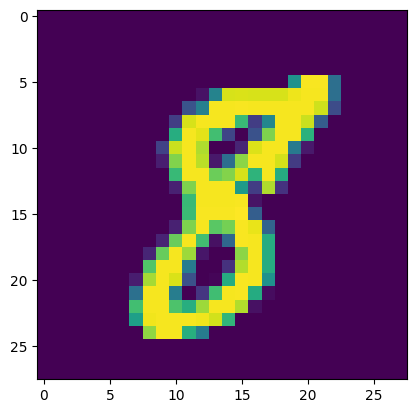

In [ ]:
plt.imshow(valid_data[2].reshape(28, 28))
plt.show()

In [ ]:
def label_to_one_hot(y, n_class):
    """Converts labels to one-hot encoding."""
    one_hot = np.zeros((y.shape[0], n_class))
    for i in range(len(y)):
        one_hot[i][int(y[i])] = 1
    return one_hot


n_classes = 10
train_label = label_to_one_hot(train_label_raw, n_classes)
valid_label = label_to_one_hot(valid_label_raw, n_classes)

In [ ]:
def data_generator(data, label, batch_size, shuffle=True):
    """
    Generates batches of data and labels efficiently.

    Args:
        data (numpy.ndarray): The input data.
        label (numpy.ndarray): The corresponding labels.
        batch_size (int): The size of each batch.
        shuffle (bool): Whether to shuffle the data before batching.

    Yields:
        Tuple of (data_batch, label_batch).
    """
    num_samples = len(data)
    indices = np.arange(num_samples)

    if shuffle:
        np.random.shuffle(indices)

    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        batch_indices = indices[start:end]

        yield data[batch_indices], label[batch_indices]

In [ ]:
def conv_output_size(input_size, filter_size, stride=1, pad=0):
    return int((input_size + 2*pad - filter_size) / stride) + 1


In [ ]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [ ]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]


In [ ]:
class Layer(ABC):
    """The base class for NN model layer."""
    def __init__(self):
        pass

    @abstractmethod
    def forward(self, x):
        raise NotImplementedError

    @abstractmethod
    def backward(self, dout):
        raise NotImplementedError

In [ ]:
class Linear(Layer):
    def __init__(self, input_dim, output_dim):
        self.params = {}
        self.params['W'] = np.random.randn(input_dim, output_dim) / np.sqrt(input_dim)
        self.params['b'] = np.random.randn(output_dim)
        self.grads = {}

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.params['W']) + self.params['b']
        return out

    def backward(self, dout):
        self.grads['W'] = np.dot(self.x.T, dout)
        self.grads['b'] = np.sum(dout, axis=0)
        return np.dot(dout, self.params['W'].T)

In [ ]:
class ReLU(Layer):
    def __init__(self):
        self.params = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        return dout

In [ ]:
class Conv2d(Layer):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, pad=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.pad = pad

        self.params = {}
        self.params['W'] = np.random.randn(
            out_channels, in_channels, kernel_size[0], kernel_size[1]
        ) / np.sqrt(in_channels * kernel_size[0] * kernel_size[1])
        self.params['b'] = np.zeros(out_channels)

        self.grads = {}
        self.grads['W'] = np.zeros_like(self.params['W'])
        self.grads['b'] = np.zeros_like(self.params['b'])

        self.x = None
        self.col = None
        self.col_W = None

    def forward(self, x):
        W, b = self.params['W'], self.params['b']
        FN, C, FH, FW = W.shape
        N, _, H, W_ = x.shape
        out_h = (H + 2 * self.pad - FH) // self.stride + 1
        out_w = (W_ + 2 * self.pad - FW) // self.stride + 1

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = W.reshape(FN, -1).T

        out = np.dot(col, col_W) + b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        W = self.params['W']
        FN, C, FH, FW = W.shape

        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)

        self.grads['b'] = np.sum(dout, axis=0)
        dW = np.dot(self.col.T, dout)
        self.grads['W'] = dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


In [ ]:
class MaxPool2d(Layer):
    def __init__(self, kernel_size=(2, 2), stride=2, pad=0):
        self.pool_h = kernel_size[0]
        self.pool_w = kernel_size[1]
        self.stride = stride
        self.pad = pad

        self.params = {}
        self.grads = {}

        self.x = None
        self.arg_max = None
        self.out_h = None
        self.out_w = None
        self.pool_size = self.pool_h * self.pool_w

    def forward(self, x):
        N, C, H, W = x.shape

        self.out_h = (H + 2 * self.pad - self.pool_h) // self.stride + 1
        self.out_w = (W + 2 * self.pad - self.pool_w) // self.stride + 1

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(N, C, self.out_h, self.out_w, self.pool_size)
        col = col.transpose(0, 2, 3, 1, 4).reshape(-1, self.pool_size)

        self.arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)

        out = out.reshape(N, self.out_h, self.out_w, C).transpose(0, 3, 1, 2)

        self.x = x

        return out

    def backward(self, dout):
        N, C, out_h, out_w = dout.shape

        dout_flat = dout.transpose(0, 2, 3, 1).reshape(-1)
        dmax = np.zeros((dout_flat.size, self.pool_size))

        dmax[np.arange(dout_flat.size), self.arg_max] = dout_flat

        dmax = dmax.reshape(N, out_h, out_w, C, self.pool_size)
        dmax = dmax.transpose(0, 3, 1, 2, 4).reshape(N * C * out_h * out_w, self.pool_size)

        dx = col2im(dmax, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx


In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

In [ ]:
class SoftmaxWithCrossEntropyLoss(Layer):
    def __init__(self):
        self.params = None

    def forward(self, out, y):
        '''
            out: output of last fully connected layer
            y: true label
        '''

        batch_size = out.shape[0]

        out = softmax(out)

        self.out = out
        self.y = y

        log_out = np.log(out + 1e-7)

        loss = np.sum(-log_out * y)

        return loss / batch_size, out

    def backward(self, dout=1):
      batch_size = self.y.shape[0]
      return (self.out - self.y) / batch_size

In [ ]:
# New Layer: Dropout
class Dropout(Layer):
    def __init__(self, dropout_ratio=0.5):
        self.params = None
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flg = True

    def forward(self, x, train_flg=True):
        self.train_flg = train_flg

        if self.train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask / (1.0 - self.dropout_ratio)
        else:
            return x

    def backward(self, dout):
        if self.train_flg:
            return dout * self.mask / (1.0 - self.dropout_ratio)
        else:
            return dout

In [ ]:
# New Layer: BatchNormalization
class BatchNormalization(Layer):
    def __init__(self, gamma=1.0, beta=0.0, momentum=0.9, running_mean=None, running_var=None):
        self.params = {}
        self.params['gamma'] = gamma
        self.params['beta'] = beta
        self.momentum = momentum
        self.running_mean = running_mean
        self.running_var = running_var

        self.batch_size = None
        self.xc = None
        self.xn = None
        self.std = None

        self.grads = {}

    def forward(self, x, train_flg=True):
        if x.ndim == 4:
            # For convolutional layers
            N, C, H, W = x.shape
            x_reshaped = x.transpose(0, 2, 3, 1).reshape(-1, C)
            out = self._forward(x_reshaped, train_flg)
            return out.reshape(N, H, W, C).transpose(0, 3, 1, 2)
        else:
            # For fully connected layers
            return self._forward(x, train_flg)

    def _forward(self, x, train_flg):
        if self.running_mean is None:
            D = x.shape[1]
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)

        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 1e-7)
            xn = xc / std

            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std

            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
        else:
            xc = x - self.running_mean
            xn = xc / np.sqrt(self.running_var + 1e-7)

        out = self.params['gamma'] * xn + self.params['beta']
        return out

    def backward(self, dout):
        if dout.ndim == 4:
            # For convolutional layers
            N, C, H, W = dout.shape
            dout = dout.transpose(0, 2, 3, 1).reshape(-1, C)
            dx = self._backward(dout)
            return dx.reshape(N, H, W, C).transpose(0, 3, 1, 2)
        else:
            # For fully connected layers
            return self._backward(dout)

    def _backward(self, dout):
        dbeta = np.sum(dout, axis=0)
        dgamma = np.sum(dout * self.xn, axis=0)

        dxn = dout * self.params['gamma']
        dxc = dxn / self.std

        dstd = -np.sum(dxn * self.xc / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std

        dxc += 2.0 * self.xc * dvar / self.batch_size
        dmu = -np.sum(dxc, axis=0)
        dx = dxc + dmu / self.batch_size

        self.grads['gamma'] = dgamma
        self.grads['beta'] = dbeta

        return dx

In [ ]:
# New Layer: Global Average Pooling
class GlobalAveragePooling(Layer):
    def __init__(self):
        self.params = None
        self.grads = {}
        self.x_shape = None

    def forward(self, x):
        self.x_shape = x.shape
        N, C, H, W = x.shape
        # Average over the height and width dimensions
        out = np.mean(x, axis=(2, 3))
        return out

    def backward(self, dout):
        N, C = dout.shape
        _, _, H, W = self.x_shape

        # Distribute the gradient equally across all the elements that were averaged
        dx = np.ones(self.x_shape) * dout[:, :, np.newaxis, np.newaxis] / (H * W)
        return dx

In [ ]:
class Optimizer(ABC):
    """The base class for optimizer."""
    def __init__(self, learning_rate, layers):
        self.learning_rate = learning_rate
        self.layers = layers

    @abstractmethod
    def update(self):
        raise NotImplementedError

In [ ]:
class SGD(Optimizer):
    """SGD (Stochastic gradient descent) optimizer"""
    def __init__(self, learning_rate, layers):
        super().__init__(learning_rate, layers)

    def update(self):
        for i in range(len(self.layers)):
            layer = self.layers[i]
            if layer.params is not None:
                for key in layer.params.keys():
                    layer.params[key] -= self.learning_rate * layer.grads[key]


In [ ]:
# New Optimizer: Adam
class Adam(Optimizer):
    """Adam optimizer"""
    def __init__(self, learning_rate, layers, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(learning_rate, layers)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}  # First moment
        self.v = {}  # Second moment
        self.t = 0   # Timestep

        # Initialize momentum and velocity
        for i, layer in enumerate(self.layers):
            if layer.params is not None:
                self.m[i] = {}
                self.v[i] = {}
                for key in layer.params.keys():
                    self.m[i][key] = np.zeros_like(layer.params[key])
                    self.v[i][key] = np.zeros_like(layer.params[key])

    def update(self):
        self.t += 1

        for i, layer in enumerate(self.layers):
            if layer.params is not None:
                for key in layer.params.keys():
                    # Update biased first moment estimate
                    self.m[i][key] = self.beta1 * self.m[i][key] + (1 - self.beta1) * layer.grads[key]
                    # Update biased second raw moment estimate
                    self.v[i][key] = self.beta2 * self.v[i][key] + (1 - self.beta2) * (layer.grads[key]**2)

                    # Bias correction
                    m_corrected = self.m[i][key] / (1 - self.beta1**self.t)
                    v_corrected = self.v[i][key] / (1 - self.beta2**self.t)

                    # Update parameters
                    layer.params[key] -= self.learning_rate * m_corrected / (np.sqrt(v_corrected) + self.epsilon)


In [ ]:
# CNN Model class
class CNN:
    def __init__(self):
        # Initialize layers
        self.layers = []

        # Conv1: 1 -> 32 channels, 3x3 kernel
        self.layers.append(Conv2d(1, 32, kernel_size=(3, 3), stride=1, pad=1))
        self.layers.append(BatchNormalization())  # Add BatchNorm after first conv
        self.layers.append(ReLU())
        self.layers.append(MaxPool2d(kernel_size=(2, 2), stride=2))

        # Conv2: 32 -> 64 channels, 3x3 kernel
        self.layers.append(Conv2d(32, 64, kernel_size=(3, 3), stride=1, pad=1))
        self.layers.append(ReLU())
        self.layers.append(MaxPool2d(kernel_size=(2, 2), stride=2))

        # Conv3: 64 -> 128 channels, 3x3 kernel
        self.layers.append(Conv2d(64, 128, kernel_size=(3, 3), stride=1, pad=1))
        self.layers.append(ReLU())
        self.layers.append(Dropout(0.25))  # Add dropout layer as required

        # Global Average Pooling
        self.layers.append(GlobalAveragePooling())

        # Fully connected layer: 128 -> 10 (for 10 digits)
        self.layers.append(Linear(128, 10))

        # Loss layer (will be used separately in the forward pass)
        self.loss_layer = SoftmaxWithCrossEntropyLoss()

    def forward(self, x, t):
        train_flg = t is not None

        for layer in self.layers:
            if isinstance(layer, (Dropout, BatchNormalization)):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        if train_flg:
            loss, output = self.loss_layer.forward(x, t)
            return loss, output
        else:
            return x

    def backward(self):
        dout = self.loss_layer.backward(dout=1)

        for layer in reversed(self.layers):
            dout = layer.backward(dout)

        return dout

    def predict(self, x):
        for layer in self.layers:
            if isinstance(layer, (Dropout, BatchNormalization)):
                x = layer.forward(x, train_flg=False)
            else:
                x = layer.forward(x)


        return softmax(x)

In [ ]:
def train_mnist():
    global train_data, train_label, valid_data, valid_label

    model = CNN()

    batch_size = 256
    epochs = 10
    learning_rate = 5e-3
    optimizer = Adam(learning_rate, model.layers)

    patience = 1
    best_valid_acc = 0.0
    wait = 0

    print("Starting training...")
    for epoch in range(epochs):
        train_data, train_label = shuffle(train_data, train_label)

        train_loss, train_correct, total_batches = 0, 0, 0
        for data_batch, label_batch in data_generator(train_data, train_label, batch_size):
            loss, output = model.forward(data_batch, label_batch)
            model.backward()
            optimizer.update()

            train_loss += loss
            train_correct += np.sum(np.argmax(output, axis=1) == np.argmax(label_batch, axis=1))
            total_batches += 1

        train_loss /= total_batches
        train_accuracy = train_correct / len(train_data)

        # Validation phase
        valid_loss, valid_correct, total_batches = 0, 0, 0
        for data_batch, label_batch in data_generator(valid_data, valid_label, batch_size):
            loss, output = model.forward(data_batch, label_batch)

            valid_loss += loss
            valid_correct += np.sum(np.argmax(output, axis=1) == np.argmax(label_batch, axis=1))
            total_batches += 1

        valid_loss /= total_batches
        valid_accuracy = valid_correct / len(valid_data)

        print(f'Epoch {epoch+1}/{epochs} - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')


    return model



In [ ]:
def test_mnist(model):
    global test_data, test_label

    print("\nEvaluating on test set...")
    test_correct = 0
    batch_size = 256

    test_label_onehot = label_to_one_hot(test_label, n_classes)

    for data_batch, label_batch in data_generator(test_data, test_label_onehot, batch_size):
        _, output = model.forward(data_batch, label_batch)
        test_correct += np.sum(np.argmax(output, axis=1) == np.argmax(label_batch, axis=1))

    test_accuracy = test_correct / len(test_data)
    print(f'Test accuracy: {test_accuracy:.4f}')


In [ ]:
# Train the model
trained_model = train_mnist()

Starting training...
Epoch 1/10 - Train Loss: 0.9337, Train Acc: 0.7011, Valid Loss: 0.2522, Valid Acc: 0.9201
Epoch 2/10 - Train Loss: 0.1733, Train Acc: 0.9486, Valid Loss: 0.1428, Valid Acc: 0.9563
Epoch 3/10 - Train Loss: 0.1136, Train Acc: 0.9647, Valid Loss: 0.1344, Valid Acc: 0.9609
Epoch 4/10 - Train Loss: 0.0873, Train Acc: 0.9725, Valid Loss: 0.0954, Valid Acc: 0.9703
Epoch 5/10 - Train Loss: 0.0718, Train Acc: 0.9771, Valid Loss: 0.0897, Valid Acc: 0.9727
Epoch 6/10 - Train Loss: 0.0564, Train Acc: 0.9814, Valid Loss: 0.0796, Valid Acc: 0.9763
Epoch 7/10 - Train Loss: 0.0518, Train Acc: 0.9836, Valid Loss: 0.0753, Valid Acc: 0.9776
Epoch 8/10 - Train Loss: 0.0447, Train Acc: 0.9855, Valid Loss: 0.0805, Valid Acc: 0.9776
Epoch 9/10 - Train Loss: 0.0404, Train Acc: 0.9865, Valid Loss: 0.0868, Valid Acc: 0.9745
Epoch 10/10 - Train Loss: 0.0331, Train Acc: 0.9893, Valid Loss: 0.0812, Valid Acc: 0.9771


In [ ]:
# Test the trained model
test_mnist(trained_model)


Evaluating on test set...
Test accuracy: 0.9754
